### PIPELINE OVERVIEW
+ graph with genes as nodes and edges
+ generate a matrix from nodes based on specific parameters (features, random walk, shortest path..)
+ multidimensional matrices > embedding with tsne into 2D or 3D 
----------
+ Visualization typologies:
+ 2D PORTRAIT
+ 3D PORTRAIT
+ 3D LANDSCAPE
+ 3D SPHERE
----------

In [150]:
from multidimvis_main import *

_____
# SELECT ONE NETWORK GRAPH
_____

In [206]:
################################################
#
# Y E A S T 
#
################################################

organism = 'Yeast'

data = pickle.load( open( "input/BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.5.185.mitab.pickle", "rb" ) )

Counter(data['Interaction Detection Method'])
Counter(data['Interaction Types'])

filter_score = data[
                    #(data['Interaction Types'] == 'psi-mi:"MI:0915"(physical association)') +
                    (data['Interaction Types'] == 'psi-mi:"MI:0407"(direct interaction)') 
                    #&
                    #(data['Taxid Interactor A'] == "taxid:559292") & 
                    #(data['Taxid Interactor B'] == "taxid:559292") 
]

g = nx.from_pandas_edgelist(filter_score, '#ID Interactor A', 'ID Interactor B')
g.remove_edges_from(nx.selfloop_edges(g)) #remove self loop

G_cere = g.subgraph(max(nx.connected_components(g), key=len)) # largest connected component (lcc)

# ESSENTIAL GENES 
cere_gene =pd.read_csv("input/Saccharomyces cerevisiae.csv",
           delimiter= ',',
           skipinitialspace=True)
essential_cere = cere_gene[(cere_gene['essentiality status'] == 'E')]
essential_genes_cere_list =  essential_cere['symbols'].tolist()

degree= dict(G_cere.degree())

mg = mygene.MyGeneInfo()
a = mg.querymany(essential_genes_cere_list, scopes='symbol', species=559292)
essential_genes_cere_names = pd.DataFrame.from_dict(a)
essential_genes_cere_entrez =  essential_genes_cere_names['entrezgene'].tolist()

cleaned_entrez_list = [x for x in essential_genes_cere_entrez if str(x) != 'nan']

degree_formatted={}
for k, v in degree.items():
    degree_formatted[k.replace("entrez gene/locuslink:","")] = v
    
index= []
essential = []
for i in cleaned_entrez_list:
    for (key, val) in degree_formatted.items():
        if i==key:
            index.append(key)
            essential.append(val)  

no_essential_cere = cere_gene[(cere_gene['essentiality status'] == 'NE')]
no_essential_genes_cere_list =  no_essential_cere['symbols'].tolist()
b = mg.querymany(no_essential_genes_cere_list, scopes='symbol', species=559292)
no_essential_genes_cere_names = pd.DataFrame.from_dict(b)
no_essential_genes_cere_entrez =  no_essential_genes_cere_names['entrezgene'].tolist()
cleaned_entrez_list_no = [x for x in no_essential_genes_cere_entrez if str(x) != 'nan']

index= []
no_essential = []
for i in cleaned_entrez_list_no:
    for (key, val) in degree_formatted.items():
        if i==key:
            index.append(key)
            no_essential.append(val)
            
#df_cere = pd.DataFrame({'essential': pd.Series(essential), 'no_essential': pd.Series(no_essential)})


no_ess_id = no_essential_genes_cere_names['entrezgene']
ess_id = essential_genes_cere_names['entrezgene']

G = G_cere

#edge_list = nx.write_edgelist(G, "Yeast_edgelist_directinteractiononly.txt")

querying 1-1000...done.
querying 1001-1037...done.
Finished.
15 input query terms found no hit:
	['nan', 'YGR251W', 'YHR122W', 'TID3', 'YJR141W', 'YLR099W-A', 'MDN1', 'YLR132C', 'YLR243W', 'YMR134W
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4543...done.
Finished.
1 input query terms found dup hits:
	[('IMP2', 2)]
311 input query terms found no hit:
	['FLP1', 'REP1', 'RAF1', 'REP2', 'YAL018C', 'YAL044W-A', 'AIM1', 'YAL064C-A', 'YBL010C', 'YBL059W', 
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [211]:
################################################
#
# H U M A N 
#
################################################

organism = 'Human'

G = nx.read_edgelist('input/ppi_elist.txt',data=False)
# d_ent_sym, d_sym_ent = genent2sym()

d_gene_do = pickle.load( open( "input/d_gene_do.pkl", "rb" ) )
d_do_genes = pickle.load( open( "input/d_do_genes.pkl", "rb" ) )
d_do_names = pickle.load( open( "input/DO_names.pkl", "rb" ) )
d_names_do = {y:x for x,y in d_do_names.items()}

### GENE ID to SYN (e.g. HOVERINFO for nodes)

In [212]:
#entrez_syn = pd.read_csv('input/entrezid_syn.csv', index_col=0)
#d_entrez_syn = dict(zip(entrez_syn.index,entrez_syn['db_synonym']))

d_entrez_syn,d_syn_entrez = genent2sym()

d_gene2syn = {}
for k,v in d_entrez_syn.items():
    try:
        if k in G.nodes():
            d_gene2syn[k] = v
    except: 
           d_gene2syn['None'] = 'no entry'
            
d_genes_withsyn = {}
for g in G.nodes():
    for k,v in d_gene2syn.items():
        if g == k:
            d_genes_withsyn[g] = v
            
d_genes_nosyn = {}
for gene in G.nodes():
    if gene not in d_genes_withsyn.keys():
        d_genes_nosyn[gene] = 'no entry'
        
d_genes_all = {**d_genes_withsyn, **d_genes_nosyn}
d_genes_syn_sorted = {key:d_genes_all[key] for key in G.nodes()}

l_genes_syn=[]
for k,v in d_genes_syn_sorted.items():
    try:
        l_genes_syn.append(set(v.split('|')))
    except:
        l_genes_syn.append(v)
        
d_genes_syn_complete = {}
for i,v in enumerate(d_genes_syn_sorted.keys()):
    for idx,l in enumerate(l_genes_syn):
        if i==idx:
            d_genes_syn_complete[v] = l
            
l_features = list(d_genes_syn_complete.values())

In [213]:
l_features[:10] 

[{'TRAK2'},
 {'OGT'},
 {'GABRB2'},
 {'KCNJ2'},
 {'TRAK1'},
 {'NUP98'},
 {'ELAVL1'},
 {'OFD1'},
 {'FAM83D'},
 {'HOOK1'}]

In [214]:
print('Number of nodes i.e. genes: %s' %len(list(G.nodes())))
print('Number of edges: %s'%len(list(G.edges())))
print('Network density: %.1f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Number of nodes i.e. genes: 16376
Number of edges: 309355
Network density: 0.2%


_____
# SELECT ONF OF THE FOLLOWING DISTANCE MATRICES
_____

### + STRUCTURAL : Graph structure based
+ Adjacency
+ Random Walk with Restart
+ Centrality measures

#### IMPORT PRECALCULATED 

In [208]:
DM_adj = pd.read_csv('output_csv/Adjacency_Dataframe_'+organism+'.csv', index_col=0)
DM_m = pd.read_csv('output_csv/RWR_Dataframe_'+organism+'.csv', index_col=0)

DM_adj_r = DM_adj.round(2)
DM_m_r = DM_m.round(2)

In [209]:
DM_adj = DM_adj_r
DM_m = DM_m_r

In [210]:
df_centralities = pd.read_csv('output_csv/Features_centralities_Dataframe_'+organism+'.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(),df_centralities['degs']))
d_clos = dict(zip(G.nodes(), df_centralities['clos']))
d_betw = dict(zip(G.nodes(), df_centralities['betw']))
d_eigen = dict(zip(G.nodes(), df_centralities['eigen']))

d_centralities = dict(zip(list(G.nodes),zip(d_deghubs.values(),d_clos.values(),d_betw.values(),d_eigen.values())))
l_features = []
for i in d_centralities.items():
    k=list(i)
    l_features.append(k)

DM_centralities = pd.DataFrame(distance.squareform(distance.pdist(df_centralities, 'cosine')))

DM_centralities.index = G.nodes()
DM_centralities.columns = G.nodes()

### + FUNCTIONAL : Molecular Function

#### IMPORT PRECALCULATED 

In [158]:
DM_MF = pd.read_csv('output_csv/DistanceMatrix_goMF_Dataframe_Human.csv', index_col=0)

DM_MF_mod = DM_MF.round(decimals=4)

In [159]:
DM_MF = DM_MF_mod  

In [160]:
DM_MF

,0,1,2,3,4,5,6,7,8,9,...,15155,15156,15157,15158,15159,15160,15161,15162,15163,15164
0,0.0000,3.4641,3.3166,3.1623,4.0000,3.6056,3.3166,4.1231,3.8730,5.0000,...,3.4641,3.4641,3.4641,3.3166,3.7417,3.6056,3.6056,3.4641,3.4641,3.6056
1,3.4641,0.0000,1.0000,2.0000,2.4495,1.7321,1.7321,2.6458,2.2361,4.3589,...,1.4142,1.4142,1.4142,1.7321,2.0000,2.2361,2.2361,1.4142,1.4142,1.7321
2,3.3166,1.0000,0.0000,1.7321,2.6458,2.0000,1.4142,2.8284,2.4495,4.2426,...,1.7321,1.7321,1.7321,2.0000,2.2361,2.0000,2.0000,1.7321,1.7321,2.0000
3,3.1623,2.0000,1.7321,0.0000,2.8284,2.2361,1.7321,3.0000,2.6458,4.3589,...,2.0000,1.4142,2.0000,2.2361,2.4495,2.2361,2.2361,2.0000,2.0000,2.2361
4,4.0000,2.4495,2.6458,2.8284,0.0000,2.6458,2.6458,3.3166,3.0000,4.7958,...,2.4495,2.4495,2.4495,2.6458,2.8284,3.0000,3.0000,2.4495,2.4495,2.6458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15160,3.6056,2.2361,2.0000,2.2361,3.0000,2.4495,2.0000,3.1623,2.8284,4.4721,...,2.2361,2.2361,2.2361,2.4495,2.6458,0.0000,2.4495,2.2361,2.2361,2.4495
15161,3.6056,2.2361,2.0000,2.2361,3.0000,2.4495,2.0000,3.1623,2.8284,4.4721,...,2.2361,2.2361,2.2361,2.4495,2.6458,2.4495,0.0000,2.2361,2.2361,2.4495
15162,3.4641,1.4142,1.7321,2.0000,2.4495,1.7321,1.7321,2.6458,2.2361,4.3589,...,1.4142,1.4142,1.4142,1.7321,2.0000,2.2361,2.2361,0.0000,1.4142,1.7321
15163,3.4641,1.4142,1.7321,2.0000,2.4495,1.7321,1.7321,2.6458,2.2361,4.3589,...,1.4142,1.4142,1.4142,1.7321,2.0000,2.2361,2.2361,1.4142,0.0000,1.7321


### + FUNCTIONAL : Cellular Components

#### IMPORT PRECALCULATED 

In [161]:
DM_CC = pd.read_csv('output_csv/DistanceMatrix_goCC_Dataframe_Human.csv', index_col=0)

DM_CC_mod = DM_CC.round(decimals=4)

In [162]:
DM_CC = DM_CC_mod

In [163]:
DM_CC

,0,1,2,3,4,5,6,7,8,9,...,15408,15409,15410,15411,15412,15413,15414,15415,15416,15417
0,0.0000,2.2361,3.0000,3.0000,2.2361,3.0000,3.4641,3.3166,3.3166,3.3166,...,3.1623,3.1623,3.3166,3.0000,3.0000,2.6458,3.3166,3.7417,3.3166,3.0000
1,2.2361,0.0000,2.0000,2.0000,2.4495,2.4495,2.6458,2.4495,2.4495,2.8284,...,2.6458,2.6458,2.8284,2.4495,2.4495,2.4495,2.8284,3.0000,2.8284,2.4495
2,3.0000,2.0000,0.0000,0.0000,3.1623,1.4142,1.7321,1.4142,2.0000,2.0000,...,1.7321,1.7321,2.0000,1.4142,1.4142,1.4142,2.0000,2.2361,2.0000,1.4142
3,3.0000,2.0000,0.0000,0.0000,3.1623,1.4142,1.7321,1.4142,2.0000,2.0000,...,1.7321,1.7321,2.0000,1.4142,1.4142,1.4142,2.0000,2.2361,2.0000,1.4142
4,2.2361,2.4495,3.1623,3.1623,0.0000,3.1623,3.6056,3.4641,3.4641,3.4641,...,3.3166,3.0000,3.1623,3.1623,3.1623,2.8284,3.4641,3.6056,3.4641,3.1623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15413,2.6458,2.4495,1.4142,1.4142,2.8284,1.4142,2.2361,2.0000,2.4495,2.0000,...,1.7321,1.7321,2.0000,1.4142,1.4142,0.0000,2.0000,2.6458,2.0000,1.4142
15414,3.3166,2.8284,2.0000,2.0000,3.4641,2.0000,2.6458,2.4495,2.8284,2.4495,...,2.2361,2.6458,2.4495,2.0000,2.0000,2.0000,0.0000,3.0000,2.4495,2.0000
15415,3.7417,3.0000,2.2361,2.2361,3.6056,2.6458,2.8284,2.6458,3.0000,3.0000,...,2.8284,2.0000,2.6458,2.6458,2.6458,2.6458,3.0000,0.0000,2.6458,2.6458
15416,3.3166,2.8284,2.0000,2.0000,3.4641,2.0000,2.6458,2.4495,2.4495,1.4142,...,2.2361,2.6458,2.4495,1.4142,2.0000,2.0000,2.4495,2.6458,0.0000,2.0000


### + FUNCTIONAL : Biological Processes

#### IMPORT PRECALCULATED 

In [164]:
DM_BP = pd.read_csv('output_csv/DistanceMatrix_goBP_Dataframe_Human.csv', index_col=0)
    
DM_BP_mod = DM_BP.round(decimals=4)

In [317]:
DM_BP

,0,1,2,3,4,5,6,7,8,9,...,14370,14371,14372,14373,14374,14375,14376,14377,14378,14379
0,0.0000,2.2361,1.7321,1.7321,2.0000,2.0000,2.4495,2.8284,3.3166,2.2361,...,2.0000,1.7321,1.7321,1.7321,1.7321,2.2361,2.0000,2.4495,1.7321,2.4495
1,2.2361,0.0000,2.4495,2.4495,3.0000,2.6458,3.0000,3.3166,3.7417,2.8284,...,2.6458,2.4495,2.4495,2.4495,2.4495,2.8284,3.0000,3.0000,2.4495,3.0000
2,1.7321,2.4495,0.0000,0.0000,2.6458,1.0000,2.2361,2.6458,3.1623,2.0000,...,1.7321,1.4142,1.4142,1.4142,1.4142,2.0000,2.2361,2.2361,1.4142,2.2361
3,1.7321,2.4495,0.0000,0.0000,2.6458,1.0000,2.2361,2.6458,3.1623,2.0000,...,1.7321,1.4142,1.4142,1.4142,1.4142,2.0000,2.2361,2.2361,1.4142,2.2361
4,2.0000,3.0000,2.6458,2.6458,0.0000,2.8284,3.1623,3.4641,3.8730,3.0000,...,2.8284,2.6458,2.6458,2.6458,2.6458,3.0000,2.8284,3.1623,2.6458,3.1623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,5.9161,6.1644,5.8310,5.8310,6.2450,5.9161,6.0828,6.2450,6.4807,6.0000,...,5.9161,5.8310,5.8310,5.8310,5.8310,6.0000,5.9161,5.9161,5.8310,6.0828
566,3.4641,3.8730,3.3166,3.3166,4.0000,3.4641,3.7417,4.0000,4.3589,3.6056,...,3.4641,3.3166,3.3166,3.3166,3.3166,3.6056,3.7417,3.4641,3.3166,3.7417
567,3.0000,3.4641,2.8284,2.8284,3.6056,3.0000,3.3166,3.6056,4.0000,3.1623,...,3.0000,2.8284,2.8284,2.8284,2.8284,3.1623,3.0000,3.0000,2.8284,3.3166
568,3.1623,3.6056,3.0000,3.0000,3.7417,3.1623,3.4641,3.7417,4.1231,3.3166,...,3.1623,3.0000,3.0000,3.0000,3.0000,3.3166,3.4641,3.4641,3.0000,3.4641


In [165]:
DM_BP = DM_BP_mod

In [166]:
DM_BP

,0,1,2,3,4,5,6,7,8,9,...,14370,14371,14372,14373,14374,14375,14376,14377,14378,14379
0,0.0000,2.2361,1.7321,1.7321,2.0000,2.0000,2.4495,2.8284,3.3166,2.2361,...,2.0000,1.7321,1.7321,1.7321,1.7321,2.2361,2.0000,2.4495,1.7321,2.4495
1,2.2361,0.0000,2.4495,2.4495,3.0000,2.6458,3.0000,3.3166,3.7417,2.8284,...,2.6458,2.4495,2.4495,2.4495,2.4495,2.8284,3.0000,3.0000,2.4495,3.0000
2,1.7321,2.4495,0.0000,0.0000,2.6458,1.0000,2.2361,2.6458,3.1623,2.0000,...,1.7321,1.4142,1.4142,1.4142,1.4142,2.0000,2.2361,2.2361,1.4142,2.2361
3,1.7321,2.4495,0.0000,0.0000,2.6458,1.0000,2.2361,2.6458,3.1623,2.0000,...,1.7321,1.4142,1.4142,1.4142,1.4142,2.0000,2.2361,2.2361,1.4142,2.2361
4,2.0000,3.0000,2.6458,2.6458,0.0000,2.8284,3.1623,3.4641,3.8730,3.0000,...,2.8284,2.6458,2.6458,2.6458,2.6458,3.0000,2.8284,3.1623,2.6458,3.1623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,5.9161,6.1644,5.8310,5.8310,6.2450,5.9161,6.0828,6.2450,6.4807,6.0000,...,5.9161,5.8310,5.8310,5.8310,5.8310,6.0000,5.9161,5.9161,5.8310,6.0828
566,3.4641,3.8730,3.3166,3.3166,4.0000,3.4641,3.7417,4.0000,4.3589,3.6056,...,3.4641,3.3166,3.3166,3.3166,3.3166,3.6056,3.7417,3.4641,3.3166,3.7417
567,3.0000,3.4641,2.8284,2.8284,3.6056,3.0000,3.3166,3.6056,4.0000,3.1623,...,3.0000,2.8284,2.8284,2.8284,2.8284,3.1623,3.0000,3.0000,2.8284,3.3166
568,3.1623,3.6056,3.0000,3.0000,3.7417,3.1623,3.4641,3.7417,4.1231,3.3166,...,3.1623,3.0000,3.0000,3.0000,3.0000,3.3166,3.4641,3.4641,3.0000,3.4641


### + FUNCTIONAL : Disease Annotation

#### IMPORT PRECALCULATED 

In [167]:
DM_Disease = pd.read_csv('output_csv/DistanceMatrix_Disease_Dataframe_Human.csv', index_col=0)
    
DM_Disease_mod = DM_Disease.round(decimals=4)

In [168]:
DM_Disease = DM_Disease_mod

In [169]:
DM_Disease

,389289,4524,4353,27127,5925,10735,26259,1029,9649,1630,...,65125,6787,90678,10661,56479,63910,7287,11173,9962,5973
389289,0.0000,0.8360,0.7474,0.0000,0.7809,0.4380,0.0000,0.8075,0.0000,0.6349,...,0.9167,0.8174,0.9512,0.8946,0.8557,0.8333,0.9519,0.8557,0.8457,0.9385
4524,0.8360,0.0000,0.5027,0.8360,0.7065,0.8003,0.8360,0.7422,0.8360,0.8103,...,0.8086,0.8503,0.9680,0.8963,0.8579,0.8633,0.8343,0.8343,0.8988,0.9596
4353,0.7474,0.5027,0.0000,0.7474,0.7509,0.8580,0.7474,0.7893,0.7474,0.8309,...,0.7474,0.8155,0.9630,0.9201,0.8906,0.7895,0.8906,0.8177,0.8441,0.9378
27127,0.0000,0.8360,0.7474,0.0000,0.7809,0.4380,0.0000,0.8075,0.0000,0.6349,...,0.9167,0.8174,0.9512,0.8946,0.8557,0.8333,0.9519,0.8557,0.8457,0.9385
5925,0.7809,0.7065,0.7509,0.7809,0.0000,0.7127,0.7809,0.5784,0.7809,0.8000,...,0.9087,0.9200,0.9679,0.9307,0.8103,0.8174,0.8630,0.8735,0.9324,0.9595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63910,0.8333,0.8633,0.7895,0.8333,0.8174,0.9063,0.8333,0.8717,0.8333,0.9391,...,0.8333,0.8174,0.9024,0.7892,0.7113,0.0000,0.9038,0.7113,0.6914,0.8769
7287,0.9519,0.8343,0.8906,0.9519,0.8630,0.9730,0.9519,0.9074,0.9519,0.9649,...,0.8797,0.8946,0.9296,0.9391,0.6667,0.9038,0.0000,0.8750,0.9109,0.9645
11173,0.8557,0.8343,0.8177,0.8557,0.8735,0.9189,0.8557,0.9444,0.8557,0.9473,...,0.6392,0.8419,0.9155,0.8174,0.7500,0.7113,0.8750,0.0000,0.7327,0.8401
9962,0.8457,0.8988,0.8441,0.8457,0.9324,0.9133,0.8457,0.9109,0.8457,0.9437,...,0.8457,0.8310,0.9096,0.8048,0.7327,0.6914,0.9109,0.7327,0.0000,0.8860


_____
### SELECT ONE DISTANCE MATRIX

In [287]:
#---------------
# STRUCTURAL
#---------------
#feature = 'adj'
#DM = DM_adj

#feature = 'rwr'
#DM = DM_m

#feature = 'centralities'
#DM = DM_centralities


#---------------
# FUNCTIONAL 
#---------------

#feature = 'bioproc'
#DM = DM_BP
#feature = 'molfunc'
#DM = DM_MF
feature = 'cellcomp'
DM = DM_CC

#feature = 'disease'
#DM = DM_Disease


# set gene list (= G.nodes())
genes = []
for i in DM.index:
    genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

____________
# VISUAL PRE-SETTINGS
____________

In [220]:
edge_width = 0.1
edge_color = 'lightgrey'
edge_colordark = 'dimgrey'
opacity_edges = 0.5

opacity_nodes = 1.0
node_edge_col = None

### NODE SIZE

In [288]:
scalef= 0.2
size = list(draw_node_degree(G, scalef).values())

scalef= 0.15
size3d = list(draw_node_degree_3D(G, scalef).values())

### NODE + EDGE COLOUR PARAMETERS

+ COLOR > GRADIENT : BY DICT INPUT (e.g. different values for nodes, like Closeness Centrality) 

In [289]:
# ----------------------------------------------------        
# Define colour parameter with dict (gradient)
# ----------------------------------------------------        
color_method = 'clos'
d_to_be_coloured = d_clos # dict sorted by dict.values (that way the biggest value matches darkest colour of palette)


# Colouring
colour_groups = set(d_to_be_coloured.values())
colour_count = len(colour_groups)
pal = sns.color_palette('Reds', colour_count)
palette = pal.as_hex()

d_colourgroups = {}
for n in colour_groups:
    d_colourgroups[n] = [k for k in d_to_be_coloured.keys() if d_to_be_coloured[k] == n]
    
d_colourgroups_sorted = {key:d_colourgroups[key] for key in sorted(d_colourgroups.keys())}

d_val_col = {}
for idx,val in enumerate(d_colourgroups_sorted):
    for ix,v in enumerate(palette):
        if idx == ix:
            d_val_col[val] = v
d_node_colour = {}
for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
    for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
        if x[0] == y[1]:
            d_node_colour[y[0]]=x[1]
            
# SORT dict based on G.nodes
d_node_colour_sorted = dict([(key, d_node_colour[key]) for key in G.nodes()])

l_col_clos = list(d_node_colour_sorted.values())

colours_hex = l_col_clos 


d_val_col = {}
for idx,val in enumerate(d_colourgroups_sorted):
    for ix,v in enumerate(pal):
        if idx == ix:
            d_val_col[val] = v
d_node_colour = {}
for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
    for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
        if x[0] == y[1]:
            d_node_colour[y[0]]=x[1]
            
# SORT dict based on G.nodes
d_node_colour_sorted = dict([(key, d_node_colour[key]) for key in G.nodes()])

l_col = list(d_node_colour_sorted.values())

colours = l_col

KeyError: '66008'

+ COLOR SPECIFIC GENES (LIST)

In [77]:
# ----------------------------------------------------        
# Essential genes 
# ----------------------------------------------------  
     
color_method = 'Essentiality' 
color = 'blue'

l_genes = essentials

# n o d e s 
colours = color_nodes_from_genelist(G, l_genes, color)

# e d g e s 
#d_edge_color_unsort = color_edges_from_genelist(G, l_genes, color)
#d_edge_color_sorted =  {key:d_edge_color_unsort[key] for key in G.edges()}
#edge_col = list(d_edge_color_sorted.values())

In [195]:
def color_edges_from_genelist(G, l_genes, color):
    edge_lst = [(u,v) for u,v in G.edges(l_genes) if u in l_genes and v in l_genes]

    d_col_edges = {}
    for e in edge_lst:
        d_col_edges[e]=color
        
    d_nocol_edges = {}
    for e in G.edges():
        if e not in l_genes:
            d_nocol_edges[e]='lightgrey'
            
    d_both = {**d_col_edges, **d_nocol_edges}

    return d_both

In [ ]:
d_edge_color_unsort = color_edges_from_genelist(G, l_genes, color)

In [ ]:
# fix edge coloring 

In [ ]:
for i in d_edge_color_sorted.values():
    if i != 'lightgrey':
        print(i)

In [ ]:
# ----------------------------------------------------        
# Cancer Driver Genes
# ----------------------------------------------------  
     
color_method = 'Cancer Drivers' 
color = 'blue'

# n o d e s 
l_genes = l_cancerdrivers # my list of gene identifiers
colours = color_nodes_from_genelist(G, l_genes, color)

# e d g e s 
edge_color = list(color_edges_from_genelist(G, l_genes, color).values())

In [ ]:
# ----------------------------------------------------        
# Rare disease genes 
# ----------------------------------------------------  
     
color_method = 'Rare Disease Genes' 
color = 'red'

# l_genes = 

# n o d e s 
# colours = color_nodes_from_genelist(G, l_genes, 'red')

# e d g e s 
# edge_color = color_edges_from_genelist(G, l_genes, color)

## ANNOTATIONS 

In [ ]:
# ----------------------------------------------------        
# annotations 
# ----------------------------------------------------        

# Choose Specific Gene to annotate 
geneid = '4790'
genesyn = d_geneid_IBDsyn['4790'] 

x_gene = posG[geneid][0]
y_gene = posG[geneid][1]
z_gene = posG[geneid][2]

annotations = [dict ( 
                x=x_gene,
                y=y_gene,            
                z=z_gene, 
                showarrow=True,
                text = 'IBD GENE: '+genesyn,
                ay = -100,
                ax = -100,
                opacity = 0.8,
                arrowhead = 0,
                arrowwidth = 0.5 ,
                arrowcolor = "white" 
            )]

annotations = [dict(
                x=max(posG.values())[0],
                y=max(posG.values())[1],
                showarrow=True,
                text=disease_category,
                xanchor="right",
                ay=-100,
                ax=-100,
                opacity=0.8,
                arrowhead=0,
                arrowwidth=0.5,
                arrowcolor="white"
                )]

annotations3d = [dict(
                x=max(posG.values())[0],
                y=max(posG.values())[1],
                z=max(posG.values())[2],
                showarrow=True,
                text=disease_category,
                xanchor="right",
                ay=-100,
                ax=-100,
                opacity=0.8,
                arrowhead=0,
                arrowwidth=0.5,
                arrowcolor="white"
                )]

____________
# 2D 
____________

In [132]:
# make classes + functions 
# for each layout typology

___
## PORTRAITS
___

### tSNE EMBEDDING 2D

In [290]:
prplxty = 30 # range: 5-50 / default = 30
density = 1.1  # default 12.
l_rate = 200 # default 200.
steps = 250 # min 250

metric = 'cosine'

In [291]:
%%time 
tsne = embed_tsne_2D(DM, prplxty, density, l_rate, steps, metric)

CPU times: user 7min 6s, sys: 10.4 s, total: 7min 16s
Wall time: 1min 35s


In [292]:
# MAIN (if not all G.nodes)
posG_tsne = get_posG_2D(genes, tsne)

# REST (if main = G.nodes then rest will be ignored / empty)
# generate circle coordinates for rest genes (without e.g. GO term or Disease Annotation)
t = np.random.uniform(0,2*np.pi,len(genes_rest))
r = np.random.uniform(99,100, len(genes_rest)) #inner + outer radius

x = r*np.cos(t)*5
y = r*np.sin(t)

rest = []
for i,j in zip(x,y):
        rest.append((i,j))
        
posG_rest = dict(zip(genes_rest, rest))

posG_all = {**posG_tsne, **posG_rest}
posG = {key:posG_all[key] for key in G.nodes()}

### 2D tSNE PORTRAITS

In [293]:
def get_node_clusterid(df, X_clusterid, n_clus, n_iterations = 1000):
    n = n_clus
    cols = generate_colorlist_nodes(n)
    
    X_clusterid = clusterid[0]
    X_id = df.index
    
    cols_to_clusters = {}
    for ix,col in enumerate(cols):
        for j in X_clusterid:
            if j == ix:
                cols_to_clusters[j]=col

    d_node_clusterid = {k:v for k,v in zip(X_id, X_clusterid)}

    return d_node_clusterid


def get_clustercenter_xy(centers, n_clus, n_iterations = 10): 
    lx = []
    ly = []
    for clu in range(n_clus):
        for i in centers:
            lx.append(i[clu][0])
            ly.append(i[clu][1])

    return lx, ly

In [294]:
# KMEANS
df_posG = pd.DataFrame(posG_tsne).T

color_method = 'kmeans'

n_clus = 200
n_iterations = 1000

iterations = range(1,n_iterations)
centers = []
clusterid = []
kmeans = KMeans(init='random', n_clusters=n_clus, random_state=0, max_iter=n_iterations, n_init=1, verbose=0)
ids = kmeans.fit_predict(df_posG) 
centers.append(kmeans.cluster_centers_)
clusterid.append(ids)

In [295]:
d_node_clusterid = get_node_clusterid(df_posG, centers, n_clus, n_iterations)
cluster_center_x, cluster_center_y = get_clustercenter_xy(centers, n_clus, n_iterations)

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict(G, d_node_clusterid)
colours_tsne = {key:colours_unsort[key] for key in posG_tsne.keys()}

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest, 'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

trace_centers = pgo.Scatter(x = cluster_center_x,
                             y = cluster_center_y,
                                 mode = 'markers',
                                 marker=dict(
                                    size=10,
                                    color='black',
                                    opacity=1)
                                 )

annotations = [dict(
                x=xi,
                y=yi,
                showarrow=True,
                text="Cluster: "+str(i),
                xanchor="right",
                ay=-100,
                ax=-0,
                opacity=0.8,
                arrowhead=0,
                arrowwidth=0.5,
                arrowcolor="dimgrey"
                ) for i, xi, yi in zip(range(1,n_clus+1), cluster_center_x,cluster_center_y)]

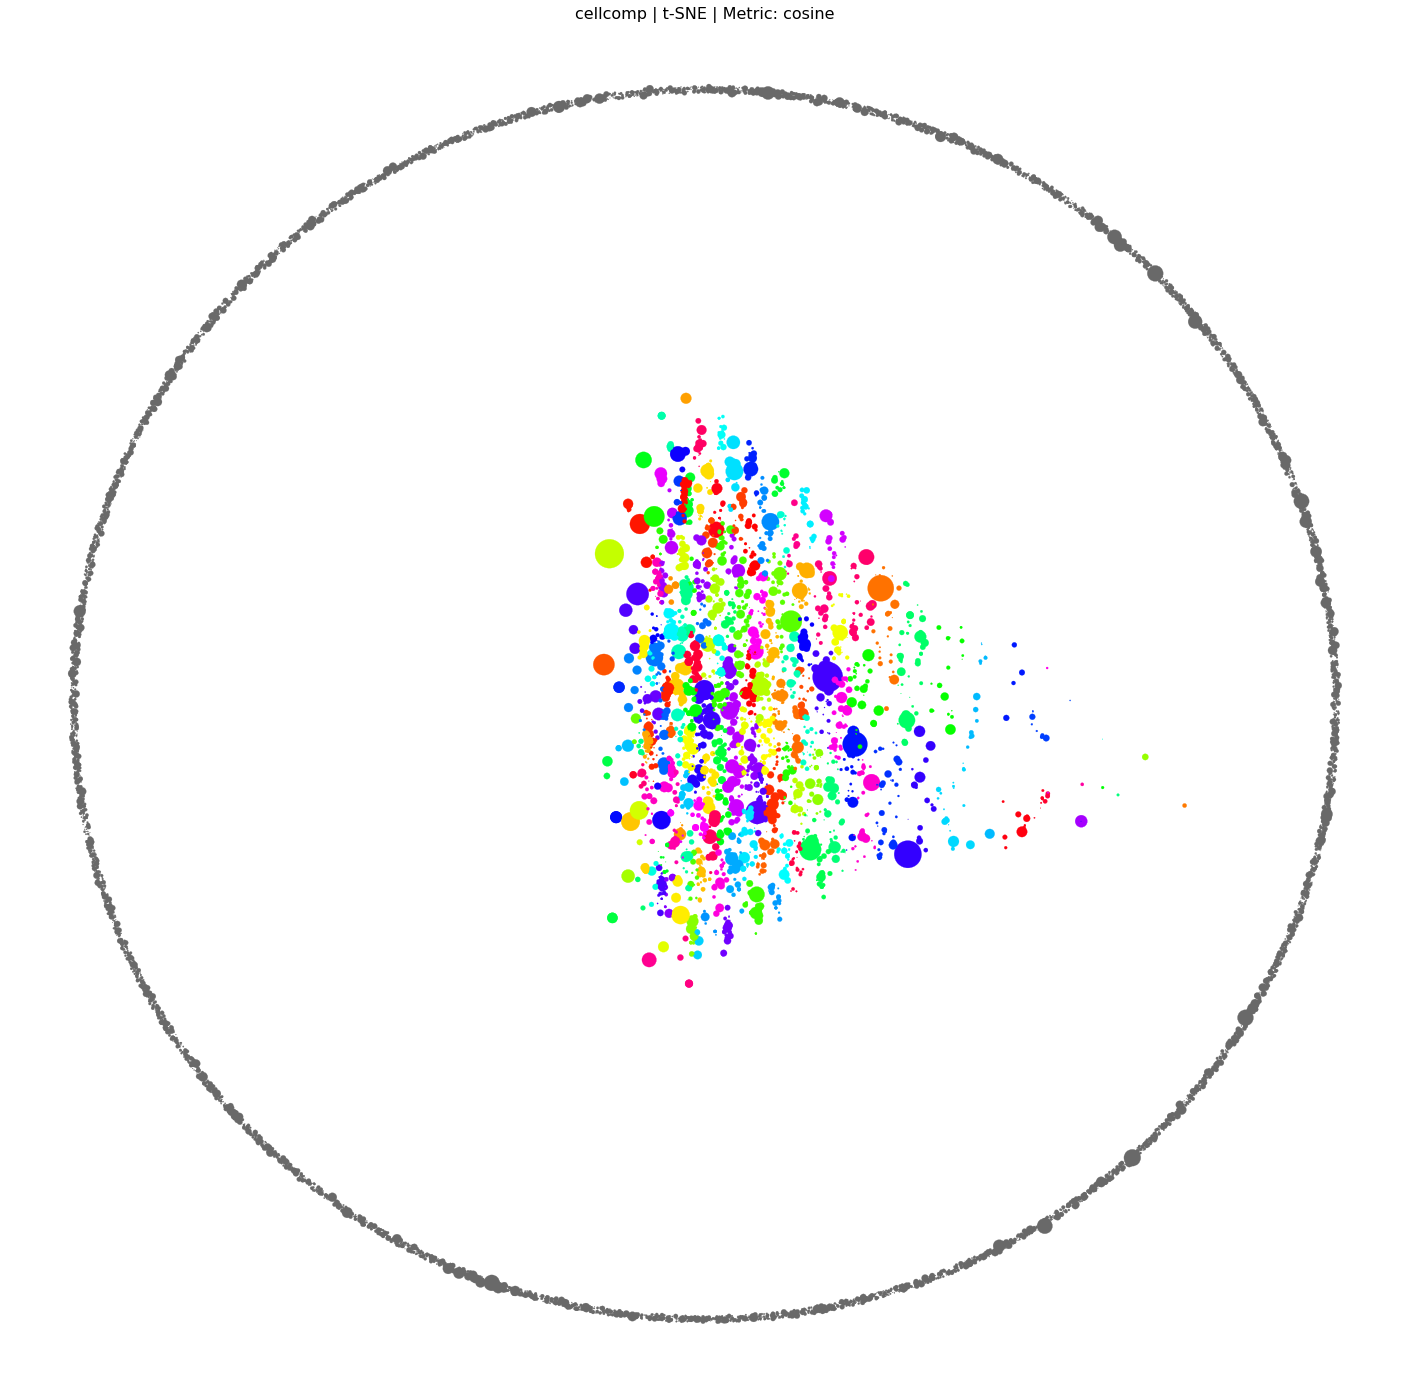

In [296]:
plt.figure(figsize=(25,25))
plt.title(feature+' | t-SNE | Metric: '+metric, size= 16)

nx.draw_networkx_nodes(G, posG, edgecolors = node_edge_col, linewidths = 0.25, node_color = colours, node_size=size, alpha = opacity_nodes)
#nx.draw_networkx_edges(G, posG, width = edge_width, edge_color = edge_col, alpha = opacity_edges)

plt.box(False)

plt.savefig('output_plots/2Dtsne_'+feature+'_'+metric+'_'+str(prplxty)+'_'+str(density)+'_'+str(l_rate)+'_'+str(steps)
        +'_'+organism+'_'+color_method+'_nx.png')

plt.show()

### UMAP EMBEDDING 2D 
+https://umap-learn.readthedocs.io/en/latest/embedding_space.html

In [297]:
n_neighbors = 5 # balance between local and global structure in the data
spread = 1.
min_dist = 0.5 # defines how dense points are stacked together 
metric ='cosine'

In [298]:
%%time 
umap = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)

CPU times: user 56.4 s, sys: 4.82 s, total: 1min 1s
Wall time: 45.5 s


In [311]:
# MAIN (if not all G.nodes)
posG_umap = get_posG_2D(genes, umap)

# REST (if main = G.nodes then rest will be ignored / empty)
# generate circle coordinates for rest genes (without e.g. GO term or Disease Annotation)
t = np.random.uniform(0,2*np.pi,len(genes_rest))
r = np.random.uniform(23,24,len(genes_rest)) #inner + outer radius

x = r*np.cos(t)*5
y = r*np.sin(t)

rest = []
for i,j in zip(x,y):
        rest.append((i,j))
        
posG_rest = dict(zip(genes_rest, rest))

posG_all = {**posG_umap, **posG_rest}
posG = {key:posG_all[key] for key in G.nodes()}

### 2D UMAP PORTRAITS

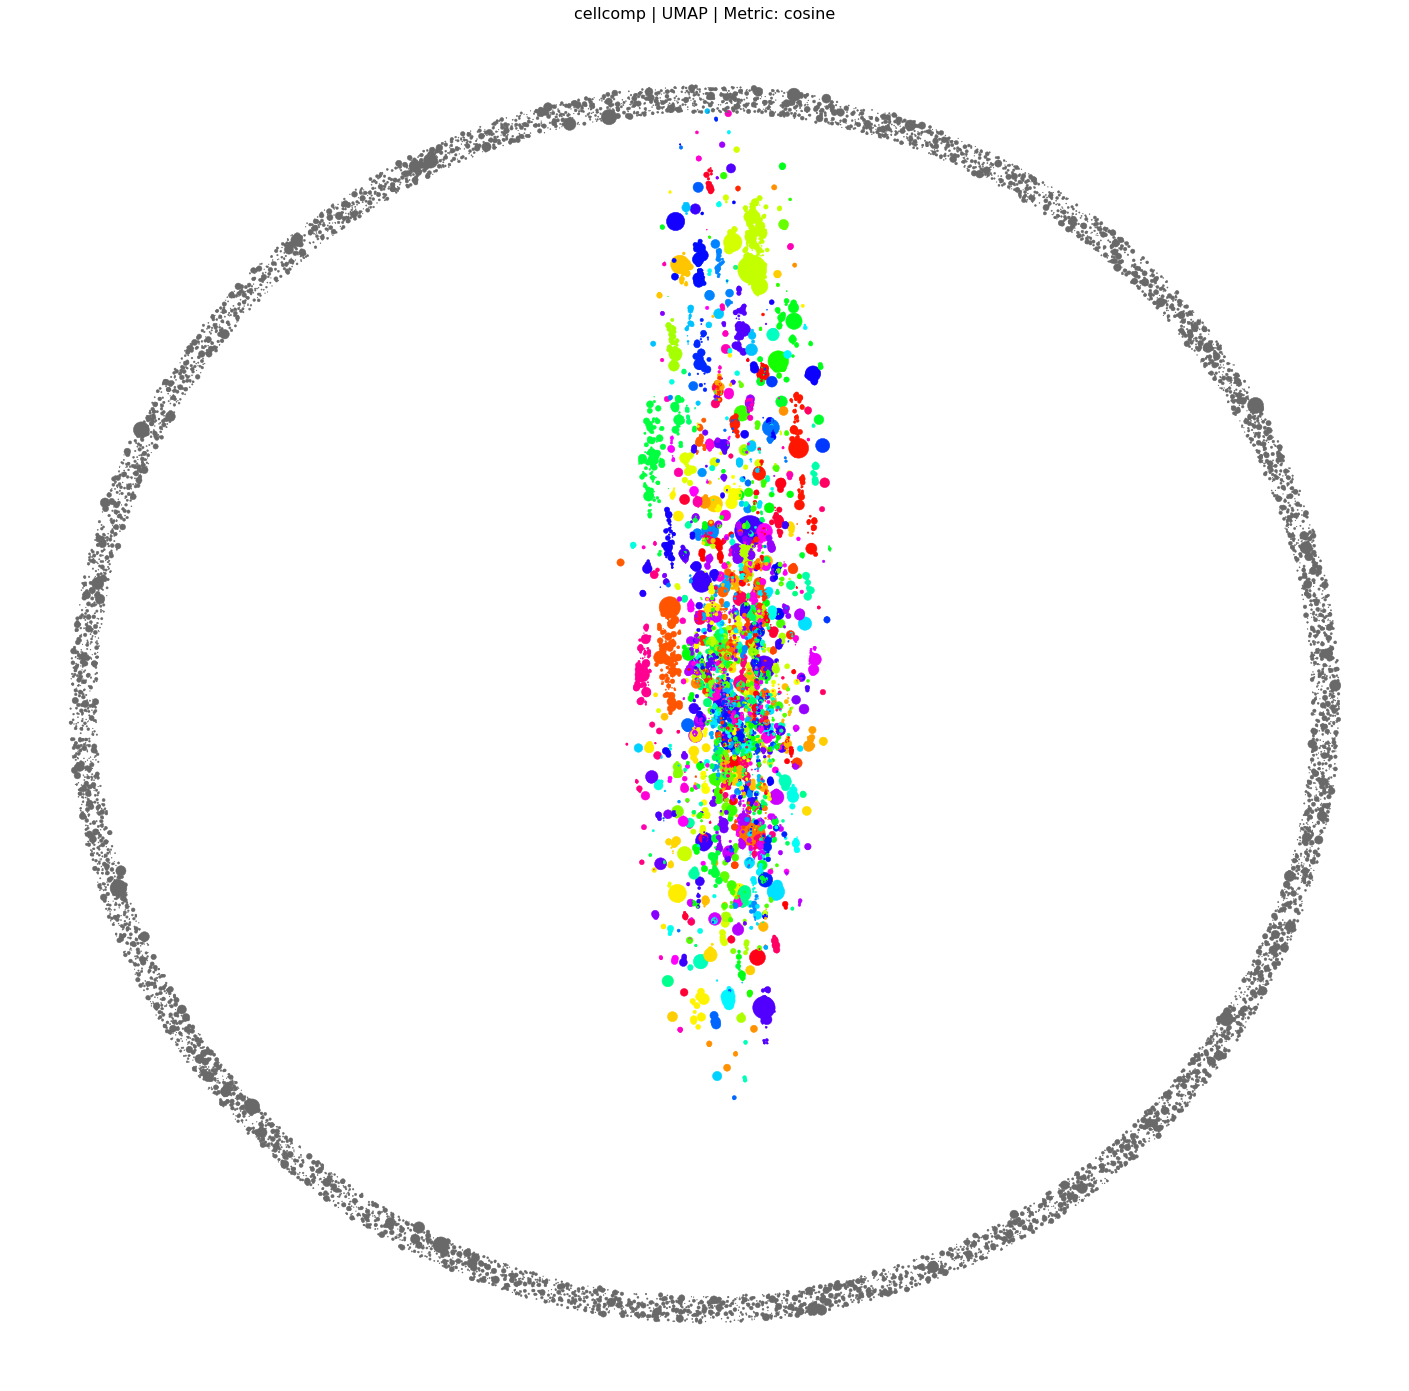

In [312]:
plt.figure(figsize=(25,25))
plt.title(feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
#nx.draw_networkx_edges(G, posG, width = edge_width, edge_color = edge_color, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

____________
# 3D
____________


____
## 3D PORTRAITS
____

In [398]:
prplxty3d = 30 # range: 5-50 / default = 30.#
density3d = 12 # default 12.
l_rate3d = 1000 # default 200.
steps3d = 250 #min 250

#metric = 'correlation'
metric = 'cosine'

In [399]:
%%time
tsne_3D = embed_tsne_3D(DM, prplxty3d, density3d, l_rate3d, steps3d)

CPU times: user 11min 37s, sys: 12.8 s, total: 11min 50s
Wall time: 1min 55s


In [458]:
# MAIN (if not all G.nodes)
posG_3Dtsne = get_posG_3D(genes, tsne_3D)

# REST (if genes = G.nodes then rest will be ignored / empty)
# generate spherical coordinates for rest genes (without e.g. GO term or Disease Annotation)
indices = arange(0, len(genes_rest))
phi = arccos(1 - 2*indices/len(genes_rest))
theta = pi * (1 + 5**0.5) * indices

r = 2
x, y, z = r*cos(theta) * sin(phi),2*r*sin(theta) * sin(phi), r*cos(phi)

rest_points = []
for i,j,k in zip(x,y,z):
    rest_points.append((i,j,k))

posG_rest = dict(zip(genes_rest, rest_points))

posG_all = {**posG_3Dtsne, **posG_rest}
posG_3D = {key:posG_all[key] for key in G.nodes()}

In [459]:
# KMEANS
df_posG = pd.DataFrame(posG_3Dtsne).T

color_method = 'kmeans'

n_clus = 50
n_iterations = 1000

iterations = range(1,n_iterations)
centers = []
clusterid = []
kmeans = KMeans(init='random', n_clusters=n_clus, random_state=0, max_iter=n_iterations, n_init=1, verbose=0)
ids = kmeans.fit_predict(df_posG) 
centers.append(kmeans.cluster_centers_)
clusterid.append(ids)

In [460]:
# Clustering 3D 

d_node_clusterid = get_node_clusterid(df_posG, n_clus, n_iterations)
#cluster_center_x, cluster_center_y, cluster_center_z = get_clustercenter_xyz(df_posG, n_clus, n_iterations)

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict(G, d_node_clusterid)
colours_tsne = {key:colours_unsort[key] for key in posG_3Dtsne.keys()}

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest, 'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

#trace_centers = pgo.Scatter3d(x = cluster_center_x,
#                             y = cluster_center_y,
#                             z = cluster_center_z,
#                                 mode = 'markers',
#                                 marker=dict(
#                                    size=3,
#                                    color='lightgrey',
#                                    opacity=1)
#                                 )

#annotations = [dict(
#                x=xi,
#                y=yi,
#                z=zi,
#                showarrow=True,
#                text="Cluster: "+str(i),
#                xanchor="right",
#                ay=-100,
#                ax=-100,
#                opacity=0.8,
#                arrowhead=0,
#                arrowwidth=0.5,
#                arrowcolor="white"
#                ) for i, xi, yi, zi in zip(range(1,n_clus+1), cluster_center_x,cluster_center_y,cluster_center_z)]

In [465]:
tsne_nodes = get_trace_nodes(posG_3D, l_features, colours, 1)#size3d)
tsne_edges = get_trace_edges(G, posG_3D, edge_colordark)

tsne_data = [tsne_edges, tsne_nodes]
#tsne_data = [tsne_nodes]

In [466]:
print('Perplexity:', prplxty3d)
print('Early Exaggeration:', density3d)
print('Learning rate:', l_rate3d)
print('Iterations:', steps3d)

fig = pgo.Figure()
for i in tsne_data:
    fig.add_trace(i)
fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      aspectratio=dict(
                        x=1,
                        y=1,
                        z=1
                    ),
                    camera=dict(
                        center=dict(
                            x=0,
                            y=0,
                            z=0
                        ),
                        eye=dict(
                            x=1.96903462608,
                            y=-1.09022831971,
                            z=0.405345349304
                        ),
                        up=dict(
                            x=0,
                            y=0,
                            z=1
                        )
                    ),
                    dragmode="turntable",
                    #annotations=annotations,
                ))
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dportrait_tsne_'+feature+'_'+metric+'_'+organism+'.html', auto_open=True)

Perplexity: 30
Early Exaggeration: 12
Learning rate: 1000
Iterations: 250


'output_plots/3Dportrait_tsne_cellcomp_cosine_Human.html'

#### UMAP

In [426]:
n_neighbors = 3 # balance between local and global structure in the data
spread = 1.
min_dist = .1 # defines how dense points are stacked together 
metric='cosine'

In [ ]:
%%time 
umap_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)
posG_3D = get_posG_3D(genes, umap_3D)

In [199]:
%%time 
umap_edges = get_trace_edges(G, posG_3D, edge_colordark) 
umap_nodes = get_trace_nodes(posG_3D,  l_features, colours, size3d)

umap_data = [umap_edges, umap_nodes]
#umap_data = [umap_nodes]


KeyboardInterrupt



In [200]:
print('# Neighbours:', n_neighbors)
print('Spread:',spread)
print('Min. Distance:', min_dist)


fig = pgo.Figure()
for i in umap_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      aspectratio=dict(
                        x=1,
                        y=1,
                        z=1
                    ),
                    camera=dict(
                        center=dict(
                            x=0,
                            y=0,
                            z=0
                        ),
                        eye=dict(
                            x=1.96903462608,
                            y=-1.09022831971,
                            z=0.405345349304
                        ),
                        up=dict(
                            x=0,
                            y=0,
                            z=1
                        )
                    ),
                    dragmode="turntable",
                    #annotations=annotations,
                ))    

plotly.offline.plot(fig, filename = 'output_plots/3Dportrait_umap_'+feature+'_'+metric+'_'+organism+'.html', auto_open=True)

# Neighbours: 3
Spread: 1.0
Min. Distance: 0.1


'output_plots/3Dportrait_umap_rwr_cosine_Human.html'

#### UMAP PORTRAIT EXPORT Coordinates

In [ ]:
# EXPORT as dataframe

df_3Dportrait_umap = pd.DataFrame(umap_posG3d).T
df_3Dportrait_umap.to_csv(r'output_csv/3DPortrait_umap_'+feature+'_'+organism+'_'+'lrate_'+l_rate3d+'steps_'+steps3d+'_'+metric+'.csv', index = True)

In [ ]:
# IMPORT and convert df to dict 
df_umap_posG3d = pd.read_csv('output_csv/3DPortrait_umap_'+feature+'_'+organism+'_'+'lrate_'+l_rate3d+'steps_'+steps3d+'_'+metric+'.csv', index_col=0)
X_umap = list(df_umap_posG3d['0'])
Y_umap = list(df_umap_posG3d['1'])
Z_umap = list(df_umap_posG3d['2'])

umap_posG3d = dict(zip(list(G.nodes()),zip(X_umap,Y_umap,Z_umap)))

___
## LANDSCAPES
___

In [ ]:
# TO DO 
# count of functions a gene is associated with (i.e. each "plane" indicates a different number of functions of genes)


In [ ]:
dict_z = {}
for i in G.nodes():
    if i in genes:
        dict_z[]

In [255]:
# ----------------------------------------------------        
# Define z-parameter
# ---------------------------------------------------- 

# Degree Centrality
dict_z = {key:d_clos[key] for key in G.nodes()}

# Essentiality
#dict_z = d_essentiality_scores_sorted


z_list = list(dict_z.values())

KeyError: '66008'

### tSNE

In [185]:
posG_land = {}
cc = 0
for k,v in posG_tsne.items():
    posG_land[k] = (v[0],v[1],z_list[cc])
    cc+=1
    
tsne_nodes = get_trace_nodes(posG_land, l_features, colours, size3d)
tsne_edges = get_trace_edges(G, posG_land, edge_colordark)

tsne_data = [tsne_edges, tsne_nodes]
#tsne_data = [tsne_nodes]

In [186]:
print('Perplexity:', prplxty)
print('Early Exaggeration:', density)
print('Learning rate:', l_rate)
print('Iterations:', steps)

fig = pgo.Figure()
for i in tsne_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      aspectratio=dict(
                        x=1,
                        y=1,
                        z=1
                    ),
                    camera=dict(
                        center=dict(
                            x=0,
                            y=0,
                            z=0
                        ),
                        eye=dict(
                            x=1.96903462608,
                            y=-1.09022831971,
                            z=0.405345349304
                        ),
                        up=dict(
                            x=0,
                            y=0, 
                            z=1
                        )
                    ),
                    dragmode="turntable",
                    #annotations=annotations,
                ))
    

#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/Landscapes_tsne_'+feature+'_'+metric+'_'+organism+'.html', auto_open=True)

Perplexity: 40
Early Exaggeration: 1
Learning rate: 200
Iterations: 250


'output_plots/Landscapes_tsne_rwr_cosine_Human.html'

### UMAP

In [187]:
posG_land = {}
cc = 0
for k,v in posG_umap.items():
    posG_land[k] = (v[0],v[1],z_list[cc])
    cc+=1
    
umap_nodes = get_trace_nodes(posG_land, l_features, colours, size3d)
umap_edges = get_trace_edges(G, posG_land, edge_colordark)

umap_data = [umap_edges, umap_nodes]

In [188]:
print('# Neighbors: ', n_neighbors)
print('Spread: ', spread)
print('Min. Distance: ', min_dist)
print('Metric: ', metric)


fig = pgo.Figure()
for i in umap_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      aspectratio=dict(
                        x=1,
                        y=1,
                        z=1
                    ),
                    camera=dict(
                        center=dict(
                            x=0,
                            y=0,
                            z=0
                        ),
                        eye=dict(
                            x=1.96903462608,
                            y=-1.09022831971,
                            z=0.405345349304
                        ),
                        up=dict(
                            x=0,
                            y=0,
                            z=1
                        )
                    ),
                    dragmode="turntable",
                    #annotations=annotations,
                ))


#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/Landscapes_umap_'+feature+'_'+metric+'_'+organism+'.html', auto_open=True)

# Neighbors:  5
Spread:  1.0
Min. Distance:  0.5
Metric:  cosine


'output_plots/Landscapes_umap_rwr_cosine_Human.html'

### LANDSCAPE | EXPORT Coordinates x,y,z,rgba

In [189]:
colours_r = []
colours_g = []
colours_b = []
colours_a = []
for i in colours:
    colours_r.append(i[0])
    colours_g.append(i[1])
    colours_b.append(i[2])
    colours_a.append(0.9)

In [190]:
# t-SNE 

df_xyz_landscape_tsne = pd.DataFrame(posG_tsne, index=["x","y"]).T
df_xyz_landscape_tsne["z"] = z_list

df_xyz_landscape_tsne['r'] = colours_r
df_xyz_landscape_tsne['g'] = colours_g
df_xyz_landscape_tsne['b'] = colours_b
df_xyz_landscape_tsne['a'] = colours_a

df_xyz_landscape_tsne.to_csv(r'output_csv/landscape_tsne_XYZ_RGBA_'+feature+'_'+organism+'.csv', index = True)

In [192]:
# UMAP 

df_xyz_landscape_umap = pd.DataFrame(posG_umap, index=["x","y"]).T
df_xyz_landscape_umap["z"] = z_list

df_xyz_landscape_umap['r'] = colours_r
df_xyz_landscape_umap['g'] = colours_g
df_xyz_landscape_umap['b'] = colours_b
df_xyz_landscape_umap['a'] = colours_a

df_xyz_landscape_umap.to_csv(r'output_csv/landscape_umap_XYZ_RGBA_'+feature+'_'+organism+'.csv', index = True)

## SPHERE

#### UMAP

In [ ]:
# ----------------------------------------------------        
# Radius parameter
# ----------------------------------------------------        

In [ ]:
# Essentiality
d_param = d_essentiality_scores_sorted

In [ ]:
# Closeness Centrality
d_clos_r = {}
for i,j in d_clos.items():
    d_clos_r[i] = round(j,2)
    
d_binned = bin_nodes(d_clos_r)

d_node_bin = {}
for k,v in d_binned.items():
    for each in v:
        d_node_bin[each] = k
        
d_param = {key:d_node_bin[key] for key in G.nodes()}

In [ ]:
# Degree Centrality
d_degs_r = {}
for i,j in d_deghubs.items():
    d_degs_r[i] = round(j,1)
    
d_binned = bin_nodes(d_degs_r)

d_node_bin = {}
for k,v in d_binned.items():
    for each in v:
        d_node_bin[each] = k
        
d_param = {key:d_node_bin[key] for key in G.nodes()}

In [ ]:
# Centrality Metrics average 
d_centr = {}
for i,j in df_centralities.iterrows():
    d_centr[i] = round((j[0]+j[1]+j[2]+j[3])/4,2)
    
d_binned = bin_nodes(d_centr)

d_node_bin = {}
for k,v in d_binned.items():
    for each in v:
        d_node_bin[each] = k
        
d_param = {key:d_node_bin[key] for key in G.nodes()}

In [ ]:
len(set(d_param.values()))

In [ ]:
%%time 
umap_sphere = embed_umap_sphere(G, DM, n_neighbors, spread, min_dist, metric)
umap_sphere_withrad = get_posG_with_sphere_radius(G, umap_sphere, d_param)

In [ ]:
%%time
umap_sphere_trace_edges = get_trace_edges(G, umap_sphere_withrad, edge_colordark)
umap_sphere_trace_nodes = get_trace_umap_sphere(umap_sphere_withrad, l_features, colours, size3d)
umap_sphere_data = [umap_sphere_trace_edges, umap_sphere_trace_nodes]

In [ ]:
print('Metric:', metric)

fig = pgo.Figure()
for i in umap_sphere_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_dark', showlegend=False, autosize = True,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      #aspectratio=dict(
                      #  x=1,
                      #  y=1,
                      #  z=1
                    #),
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
    
#fig.update_layout(template='plotly_dark', showlegend=False, width=2000, height=2000)
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dsphere_umap_'+feature+'_'+metric+'_'+organism+'.html', auto_open=True)

# WORK IN PROGRESS

## Biological Node Properties

## ESSENTIALITY

In [68]:
# Essentiality Score
essentials = []
for i in ess_id:
    essentials.append('entrez gene/locuslink:'+str(i))
    
nonessentials = []
for i in no_ess_id:
    nonessentials.append('entrez gene/locuslink:'+str(i))
    
major_score = 1
minor_score = -1

d_essentiality_scores = node_essentiality_scores(G, essentials, nonessentials, major_score, minor_score)
d_essentiality_scores_sorted = {key:d_essentiality_scores[key] for key in G.nodes()}

In [ ]:
# add statistical test for checking for essentiality to degree - correlation

## CANCER DRIVERS 

## RARE DISEASE GENES

+ CLUSTERS COLOURED

# ADDITIONAL STUFF

+ HUBS COLOURED

In [136]:
feature = 'HUBS'

df_centralities = pd.read_csv('output_csv/Features_centralities_Dataframe_Human.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(),df_centralities['degs']))
d_clos = dict(zip(G.nodes(), df_centralities['clos']))
d_betw = dict(zip(G.nodes(), df_centralities['betw']))
d_eigen = dict(zip(G.nodes(), df_centralities['eigen']))

cutoff = 3 # number of considered hub nodes 
d_hub_nodes = identify_hubs(d_deghubs, d_clos, d_betw, cutoff)

colours = color_majornodes(G, d_hub_nodes)
#colours = color_nodes_from_dict(G,d_hub_nodes)
edge_color = color_majornodes_outgoingedges(G, d_hub_nodes)

# Annotations 

d_hub_coords = {}
for node,hub in d_hub_nodes.items():
    for k,v in posG.items():
        if node == str(k):
            d_hub_coords[node] = v
            
hub_x = []
hub_y = []
hub_z = []
for node,coords in d_hub_coords.items():
    hub_x.append(coords[0])
    hub_y.append(coords[1])
    hub_z.append(coords[2])
    
annotations = [dict(
                x=hub_x,
                y=hub_y,
                z=hub_z,
                showarrow=True,
                text="Hubs: "+str(i),
                xanchor="right",
                ay=-100,
                ax=-100,
                opacity=0.8,
                arrowhead=0,
                arrowwidth=0.5,
                arrowcolor="white"
                ) for i, hub_x, hub_y, hub_z in zip(range(1,len(d_hub_nodes)+1),hub_x, hub_y, hub_z)]

+ CLOSENESS CENTRALITY COLOR 

In [ ]:
feature = 'CLOSE'

# Define colour parameter
d_to_be_coloured = d_clos # dict sorted by dict.values (that way the biggest value matches darkest colour of palette)


# Colouring
colour_groups = set(d_to_be_coloured.values())
colour_count = len(colour_groups)
palette = sns.color_palette('Reds', colour_count)

d_colourgroups = {}
for n in colour_groups:
    d_colourgroups[n] = [k for k in d_to_be_coloured.keys() if d_to_be_coloured[k] == n]
    
d_colourgroups_sorted = {key:d_colourgroups[key] for key in sorted(d_colourgroups.keys())}

d_val_col = {}
for idx,val in enumerate(d_colourgroups_sorted):
    for ix,v in enumerate(palette):
        if idx == ix:
            d_val_col[val] = v
d_node_colour = {}
for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
    for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
        if x[0] == y[1]:
            d_node_colour[y[0]]=x[1]
            
# SORT dict based on G.nodes
d_node_colour_sorted = dict([(key, d_node_colour[key]) for key in G.nodes()])

l_col_clos = list(d_node_colour_sorted.values())

colours = l_col_clos 

### COLOURING SUBCATEGORIES e.g. Disease subcategory (i.e. functional property)

In [ ]:
# input = dict

n = len(sub_categories)
colors = generate_colorlist_nodes(n)

doid_coloured = {}
c=0
for k,v in sub_categories.items():
    doid_coloured[k[1]]=colors[c]
    c+=1
    
d_gene_colours = {}
for doid, gene in d_do_genes.items(): 
    for i in gene:
        for do, col in doid_coloured.items():
            if doid == do:
                d_gene_colours[i]=col

# SORT dict based on G.nodes
d_gene_colours_sorted = {key:d_gene_colours[key] for key in G.nodes()}

l_col_subcat = list(d_gene_colours_sorted.values())


# NODE COLOURING based on Subcategory
colours = l_col_subcat 
edge_color = 'lightgrey'

#sns.palplot(colours)

### COLOURING DISEASE SCORES

In [ ]:
# TO DO : MAKE FUNCTION FOR COLORING 

gene_list = gene_list_retisarc



# COLOURS GENERATED / disease score and neighboring nodes

n = len(gene_list)
color_major = generate_colorlist_nodes(n)
 
factor = 1.7 # the higher the lighter
color_minor = []
for i in color_major:
    r,g,b = hex_to_rgb(i)
    color_light = adjust_color_lightness(r,g,b,factor)
    color_minor.append(color_light)
    
    
# ------------------------------------------------------
# NODES coloured 

# Major nodes coloured
d_col_major = {}
for n in d_major_score.keys():
    for i in color_major:
        d_col_major[n] = i

d_col_minor = {}
for node,col in d_col_major.items():
    for node in d_col_major.keys():
        for nd,neigh in major_neigh.items():
            for n in neigh:
                for i in color_minor:
                    if node==nd and n not in d_col_major.keys():
                        d_col_minor[n] = i
                    
d_col = {**d_col_major,**d_col_minor}

d_grey = {}
for i in G.nodes():
    if i not in d_col.keys():
        d_grey[i] = 'lightgrey'
        
        
d_col_all = {**d_col_major, **d_col_minor, **d_grey}
d_col_all_sorted = {key:d_col_all[key] for key in G.nodes()}

l_col_all = list(d_col_all_sorted.values())

colours = l_col_all

# ------------------------------------------------------
# EDGES coloured 

edge_lst = []
for edge in G.edges():
    for e in edge:
        for node in d_col_major.keys():
            if e == node:
                edge_lst.append(edge)
                
d_col_edges = {}
for e in edge_lst:
    for node,col in d_col_major.items():
        if e[0] == node:
            d_col_edges[e]=col
        elif e[1] == node:
            d_col_edges[e]=col

d_grey_edges = {}
for edge in G.edges():
    if edge not in d_col_edges.keys(): 
        d_grey_edges[edge] = 'lightgrey'
        
d_edges_all = {**d_col_edges, **d_grey_edges}

# Sort according to G.edges()
d_edges_all_sorted = {key:d_edges_all[key] for key in G.edges()}

edge_color = list(d_edges_all_sorted.values())